!!!Understand how to manipulate Multiindex before fully understanding this Chapter

## Introduction
Linear regression excels at extrapolating **trends**, but can't learn **interactions**. XGBoost excels at learning **interactions**, but can't extrapolate **trends**. In this lesson, we'll learn how to create **"hybrid"** forecasters that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other.

## Components and Residuals
So that we can design effective hybrids, we need a better understanding of how time series are constructed. We've studied up to now three patterns of dependence: trend, seasons, and cycles. Many time series can be closely described by an additive model of just these three components plus some essentially unpredictable, entirely random error:

`series = trend + seasons + cycles + error`

Each of the terms in this model we would then call a **component** of the time series.

The residuals of a model are the difference between the target the model was trained on and the predictions the model makes -- the difference between the actual curve and the fitted curve, in other words. Plot the residuals against a feature, and you get the "left over" part of the target, or what the model failed to learn about the target from that feature.

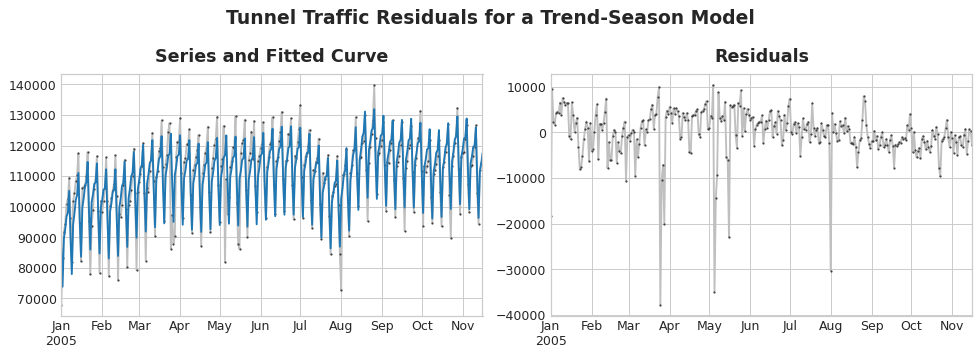
*<center>The difference between the target series and the predictions (blue) gives the series of residuals.</center>*

On the left of the figure above is a portion of the Tunnel Traffic series and the trend-seasonal curve from Lesson 3. Subtracting out the fitted curve leaves the residuals, on the right. The residuals contain everything from Tunnel Traffic the trend-seasonal model didn't learn.

We could imagine learning the components of a time series as an iterative process: first learn the trend and subtract it out from the series, then learn the seasonality from the detrended residuals and subtract the seasons out, then learn the cycles and subtract the cycles out, and finally only the unpredictable error remains.

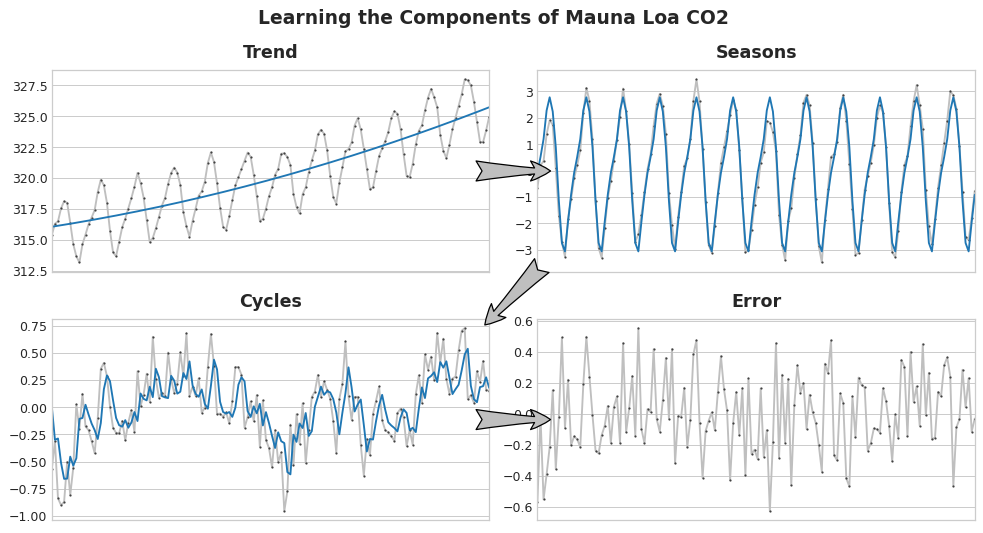

*<center>Learning the components of Mauna Loa CO2 step by step. **Subtract** the fitted curve (blue) from its series to get the series in the next step.</center>*

Add together all the components we learned and we get the complete model. This is essentially what linear regression would do if you trained it on a complete set of features modeling trend, seasons, and cycles.

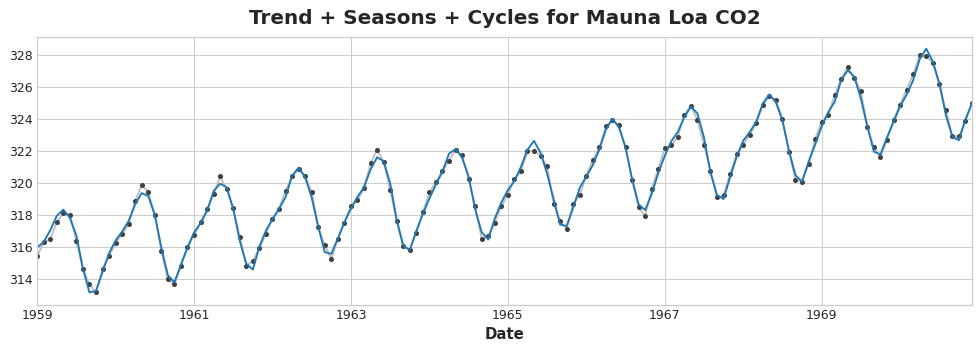
*<center>Add the learned components to get a complete model.</center>*



## Hybrid Forecasting with Residuals
In previous lessons, we used a single algorithm (linear regression) to learn all the components at once. But it's also possible to use one algorithm for some of the components and another algorithm for the rest. This way we can always choose the best algorithm for each component. To do this, we use one algorithm to fit the original series and then the second algorithm to fit the residual series.

In detail, the process is this:
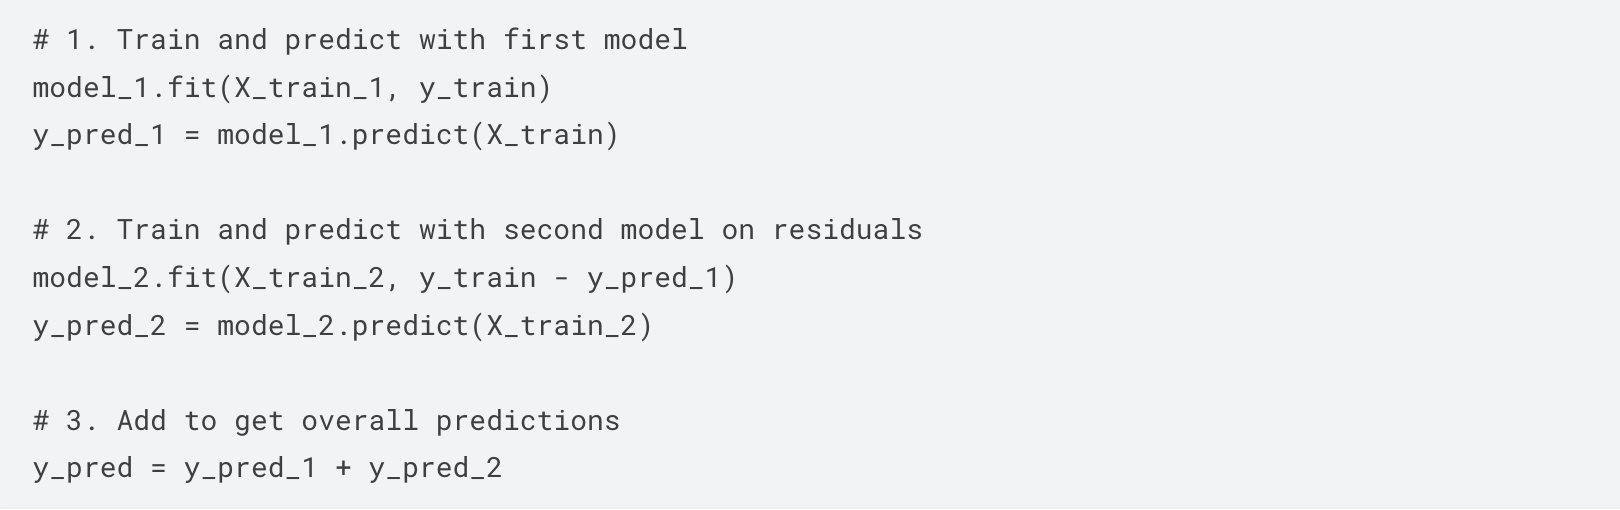

We'll usually want to use different feature sets (`X_train_1` and `X_train_2` above) depending on what we want each model to learn. If we use the first model to learn the trend, we generally wouldn't need a trend feature for the second model, for example.

While it's possible to use more than two models, in practice it doesn't seem to be especially helpful. In fact, the most common strategy for constructing hybrids is the one we've just described: a simple (usually linear) learning algorithm followed by a complex, non-linear learner like GBDTs or a deep neural net, the simple model typically designed as a "helper" for the powerful algorithm that follows.

### Designing Hybrids
There are many ways you could combine machine learning models besides the way we've outlined in this lesson. Successfully combining models, though, requires that we dig a bit deeper into how these algorithms operate.

There are generally two ways a regression algorithm can make predictions: either by **transforming the features** or by **transforming the target**. Feature-transforming algorithms learn some mathematical function that takes features as an input and then combines and transforms them to produce an output that matches the target values in the training set. Linear regression and neural nets are of this kind.

Target-transforming algorithms use the features to group the target values in the training set and make predictions by averaging values in a group; a set of feature just indicates which group to average. Decision trees and nearest neighbors are of this kind.

The important thing is this: feature transformers generally can **extrapolate** target values beyond the training set given appropriate features as inputs, but the predictions of target transformers will always be bound within the range of the training set. If the time dummy continues counting time steps, linear regression continues drawing the trend line. Given the same time dummy, a decision tree will predict the trend indicated by the last step of the training data into the future forever. Decision trees cannot extrapolate trends. Random forests and gradient boosted decision trees (like XGBoost) are ensembles of decision trees, so they also cannot extrapolate trends.
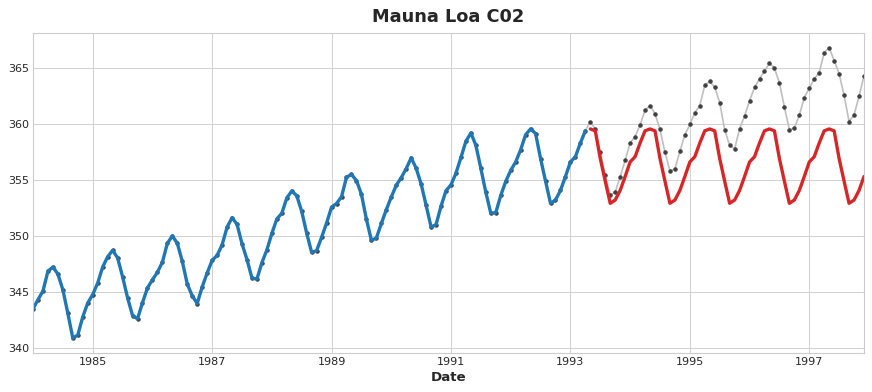
*<center>A decision tree will fail to extrapolate a trend beyond the training set.</center>*

This difference is what motivates the hybrid design in this lesson: use linear regression to extrapolate the trend, transform the target to remove the trend, and apply XGBoost to the detrended residuals. To hybridize a neural net (a feature transformer), you could instead include the predictions of another model as a feature, which the neural net would then include as part of its own predictions. The method of fitting to residuals is actually the same method the gradient boosting algorithm uses, so we will call these **boosted** hybrids; the method of using predictions as features is known as "stacking", so we will call these **stacked** hybrids.

>**Winning Hybrids from Kaggle Competitions**
>For inspiration, here are a few top scoring solutions from past competitions:
><br>
>* [STL boosted with exponential smoothing](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/discussion/8125) - Walmart Recruiting - Store Sales Forecasting
>* [ARIMA and exponential smoothing boosted with GBDT](https://www.kaggle.com/c/rossmann-store-sales/discussion/17896) - Rossmann Store Sales
>* [An ensemble of stacked and boosted hybrids](https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/39395) - Web Traffic Time Series Forecasting

## Example: US Retail Sales
The [US Retail Sales](https://www.census.gov/retail/index.html) dataset contains monthly sales data for various retail industries from 1992 to 2019, as collected by the US Census Bureau. Our goal will be to forecast sales in the years 2016-2019 given sales in the earlier years. In addition to creating a linear regression + XGBoost hybrid, we'll also see how to set up a time series dataset for use with XGBoost.

In [46]:
from pathlib import Path
from warnings import simplefilter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

data_dir = Path("./ts-course-data/")
industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    usecols=['Month']+industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)

retail = pd.concat({'Sales':retail},names=[None,'Industries'],axis=1)

retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

First let's use a linear regression model to learn the trend in each series. For demonstration, we'll use a quadratic (order 2) trend. (The code here is basically the same as that in previous lessons.) Though the fit isn't perfect, it will be enough for our needs.

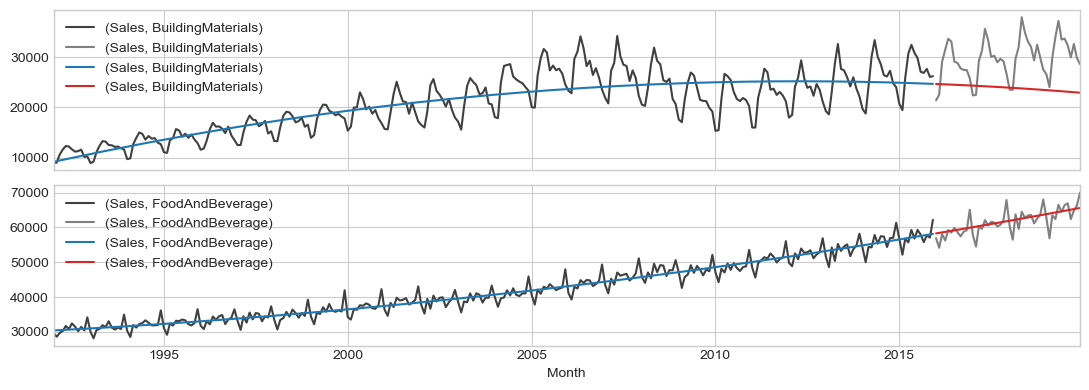

In [102]:
y = retail.copy()
dp = DeterministicProcess(
    index=y.index,   # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the da·tes given in the `index` argument
X = dp.in_sample()

X.head()
# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test =train_test_split(
    y.index,
    test_size=12*4,
    shuffle=False
)
X_train, X_test = X.loc[idx_train,:], X.loc[idx_test,:]
y_train, y_test = y.loc[idx_train,:], y.loc[idx_test]

#Fit Trend Model
model =LinearRegression()
model.fit(X_train,y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index = y_train.index,
    columns = y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y.columns,
)

# Plot
axs = y_train.plot(color='0.25',subplots=True,sharex=True)
axs = y_test.plot(color='0.5',subplots=True,sharex=True,ax=axs)
axs = y_fit.plot(color='C0',subplots=True,sharex=True,ax=axs)
axs = y_pred.plot(color='C3',subplots=True,sharex=True,ax=axs)



While the linear regression algorithm is capable of multi-output regression, the XGBoost algorithm is not. To predict multiple series at once with `XGBoost`, we'll instead convert these series from *wide* format, with one time series per column, to *long* format, with series indexed by categories along rows.

In [103]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop("Sales") # grab target series

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

So that `XGBoost` can learn to distinguish our two time series, we'll turn the row labels for 'Industries' into a categorical feature with a label encoding. We'll also create a feature for annual seasonality by pulling the month numbers out of the time index.

In [104]:
X = X.reset_index("Industries")
# Label encoding for 'Industries' features
for colname in X.select_dtypes(['object','category']):
    X[colname], _ =  X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [105]:
y_fit = y_fit.stack().squeeze()
y_pred = y_pred.stack().squeeze()

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train,y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

The fit appears quite good, though we can see how the trend learned by XGBoost is only as good as the trend learned by the linear regression -- in particular, XGBoost wasn't able to compensate for the poorly fit trend in the `'BuildingMaterials'` series.

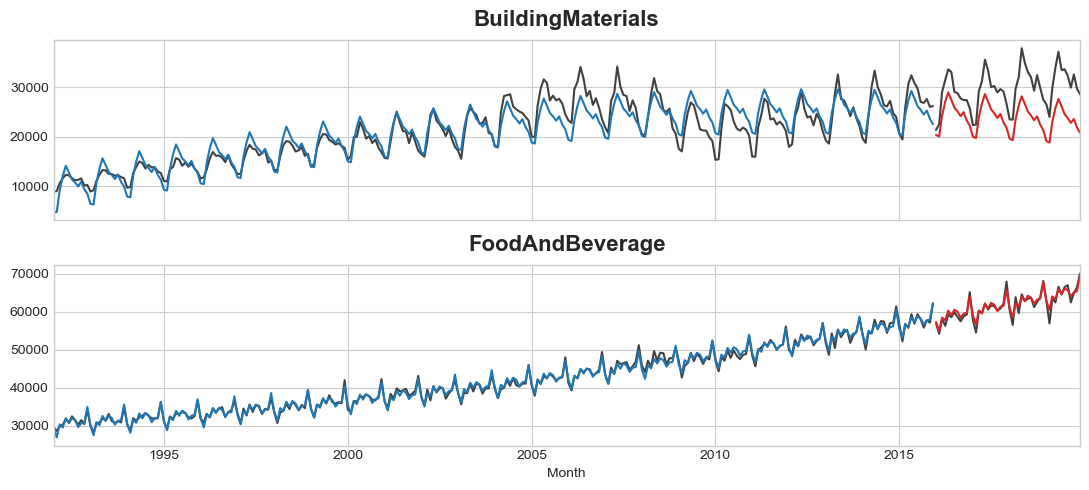

In [106]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])